In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 21 21:02:54 2019

@author: shreyas
"""
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

np.set_printoptions(threshold=np.inf)

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
df = pd.read_csv('breast-cancer-wisconsin.csv',header=None)
df.head(5)


,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


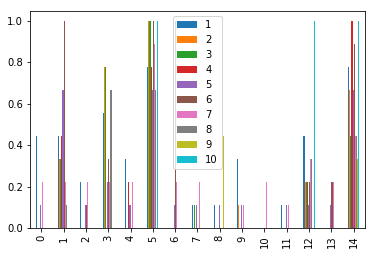

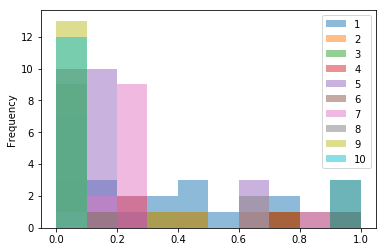

In [3]:
#to get an idea about the relation of features and their significance
df.iloc[:,10].replace(2, 0,inplace=True)
df.iloc[:,10].replace(4, 1,inplace=True)
df = df[~df[6].isin(['?'])]
df = df.astype(float)
names = df.columns[0:10]
scaler = MinMaxScaler() 
scaled_df = scaler.fit_transform(df.iloc[:,0:10]) 
scaled_df = pd.DataFrame(scaled_df, columns=names)
scaled_df[10]= df[10]
scaled_df.iloc[0:15,1:11].plot.bar();
scaled_df.iloc[0:15,1:11].plot.hist(alpha=0.5)

In [4]:
#public kaggle
def plotCf(a,b,t):
    cf =confusion_matrix(a,b)
    plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.title(t)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(a))) # length of classes
    class_labels = ['0','1']
    tick_marks
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    # plotting text value inside cells
    thresh = cf.max() / 2.
    for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
        plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
    plt.show();
    

In [5]:
def Sigmoid(Z):
    return 1/(1+np.exp(-Z))

def Relu(Z):
    return np.maximum(0,Z)
def dRelu2(dZ, Z):
    dZ[Z <=0] = 0
    return dZ
def dRelu(x):
    x[x<=0]=0
    x[x>0]=1
    return x

def dSigmoid(Z):
    s=1/(1+np.exp(-Z))
    dZ=s*(1-s)
    return dZ

  

In [6]:
class dlnet:
    def __init__(self,x,y):
        self.debug=0;
        self.X=x;
        self.Y=y;
        self.Yh=np.zeros((1,self.Y.shape[1])) 
        self.L=2
        self.dims = [9, 15, 1] 
        self.param = {}
        self.ch = {}
        self.grad = {}
        self.loss = []
        self.lr=0.003
        self.sam = self.Y.shape[1]
        
        self.threshold = 0.7 #setting confidence threshold for getting maximum accuracy

    
    def nInit(self):
        np.random.seed(1)
        self.param['W1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0]) 
        self.param['b1'] = np.zeros((self.dims[1], 1))
        self.param['W2'] = np.random.randn(self.dims[2], self.dims[1]) / np.sqrt(self.dims[1]) 
        self.param['b2'] = np.zeros((self.dims[2], 1))                
        return
    
    def forward(self):    
        Z1 = self.param['W1'].dot(self.X) + self.param['b1'] 
        A1 = Relu(Z1)
        self.ch['Z1'],self.ch['A1']=Z1,A1
        
        Z2 = self.param['W2'].dot(A1) + self.param['b2']  
        A2 = Sigmoid(Z2)
        self.ch['Z2'],self.ch['A2']=Z2,A2

        self.Yh=A2
        loss=self.nloss(A2)
        return self.Yh, loss
    
    def nloss(self,Yh):
        loss= (1./self.sam)*(-np.dot(self.Y, np.log(Yh).T)-np.dot(1-self.Y, np.log(1-Yh).T))
        return loss 
    
    
    def backward(self):
        dLoss_Yh = - (np.divide(self.Y, self.Yh ) - np.divide(1 - self.Y, 1 - self.Yh))    
        
        dLoss_Z2 = dLoss_Yh * dSigmoid(self.ch['Z2'])    
        dLoss_A1 = np.dot(self.param["W2"].T,dLoss_Z2)
        dLoss_W2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2,self.ch['A1'].T)
        dLoss_b2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1])) 
                            
        dLoss_Z1 = dLoss_A1 * dRelu(self.ch['Z1'])        
        dLoss_A0 = np.dot(self.param["W1"].T,dLoss_Z1)
        dLoss_W1 = 1./self.X.shape[1] * np.dot(dLoss_Z1,self.X.T)
        dLoss_b1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))  
        
        self.param["W1"] = self.param["W1"] - self.lr * dLoss_W1
        self.param["b1"] = self.param["b1"] - self.lr * dLoss_b1
        self.param["W2"] = self.param["W2"] - self.lr * dLoss_W2
        self.param["b2"] = self.param["b2"] - self.lr * dLoss_b2
        
        return
    


    def pred(self,x, y):  
        self.X=x
        self.Y=y
        comp = np.zeros((1,x.shape[1]))
        pred, loss= self.forward()    
    
        for i in range(0, pred.shape[1]):
            if pred[0,i] > self.threshold: comp[0,i] = 1
            else: comp[0,i] = 0
    
        print("Acc: " + str(np.sum((comp == y)/x.shape[1])))
        
        return comp
    
    def gd(self,X, Y, iter = 3000):
        np.random.seed(1)                         
    
        self.nInit()
    
        for i in range(0, iter):
            Yh, loss=self.forward()
            self.backward()
        
            if i % 500 == 0:
                print ("Cost after iteration %i: %f" %(i, loss))
                self.loss.append(loss)

        plt.plot(np.squeeze(self.loss))
        plt.ylabel('Loss')
        plt.xlabel('Iter')
        plt.title("Lr =" + str(self.lr))
        plt.show()
    
        return
                             
    
        
        

In [7]:
x=scaled_df.iloc[0:500,1:10].values.transpose()
y=df.iloc[0:500,10:].values.transpose()

xval=scaled_df.iloc[501:683,1:10].values.transpose()
yval=df.iloc[501:683,10:].values.transpose()

print(df.shape, x.shape, y.shape, xval.shape, yval.shape)

nn = dlnet(x,y)
nn.lr=0.07
nn.dims = [9, 15, 1] #no of input features for each layer

(683, 11) (9, 500) (1, 500) (9, 182) (1, 182)


Cost after iteration 0: 0.673967
Cost after iteration 500: 0.122093
Cost after iteration 1000: 0.108469
Cost after iteration 1500: 0.103673
Cost after iteration 2000: 0.100911
Cost after iteration 2500: 0.099047
Cost after iteration 3000: 0.097530
Cost after iteration 3500: 0.096368
Cost after iteration 4000: 0.095480
Cost after iteration 4500: 0.094744
Cost after iteration 5000: 0.094015
Cost after iteration 5500: 0.093277
Cost after iteration 6000: 0.092611
Cost after iteration 6500: 0.091953
Cost after iteration 7000: 0.091279
Cost after iteration 7500: 0.090472
Cost after iteration 8000: 0.089574
Cost after iteration 8500: 0.088575
Cost after iteration 9000: 0.087426
Cost after iteration 9500: 0.086303
Cost after iteration 10000: 0.085122
Cost after iteration 10500: 0.084010
Cost after iteration 11000: 0.083025
Cost after iteration 11500: 0.082001
Cost after iteration 12000: 0.080948
Cost after iteration 12500: 0.079923
Cost after iteration 13000: 0.078909
Cost after iteration 1350

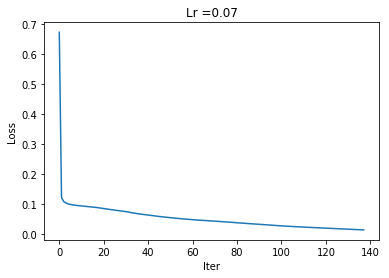

In [8]:
nn.gd(x, y, iter = 69000)

In [9]:
pred_train = nn.pred(x, y)
pred_test = nn.pred(xval, yval)

Acc: 0.9960000000000003
Acc: 0.9945054945054945


Acc: 0.9960000000000003


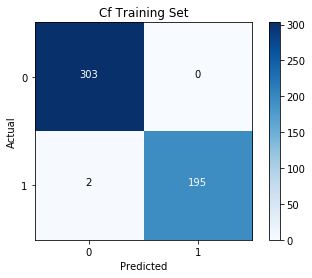

Acc: 0.9945054945054945


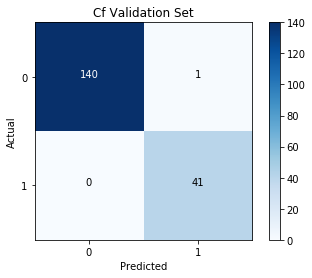

In [10]:
nn.threshold=0.7

nn.X,nn.Y=x, y 
target=np.around(np.squeeze(y), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(x,y)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Training Set')

nn.X,nn.Y=xval, yval 
target=np.around(np.squeeze(yval), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(xval,yval)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Validation Set')

In [11]:
nn.X, nn.Y= xval, yval
yvalh, loss=nn.forward()

print("\n\n y:", np.around(yval[:,0:69,], decimals=0).astype(np.int))
print("\n\n y hat:", np.around(yvalh[:,0:69,], decimals=0).astype(np.int), "\n\n")



 y: [[0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0]]


 y hat: [[0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0]] 


